1 

<IPython.core.display.Javascript object>


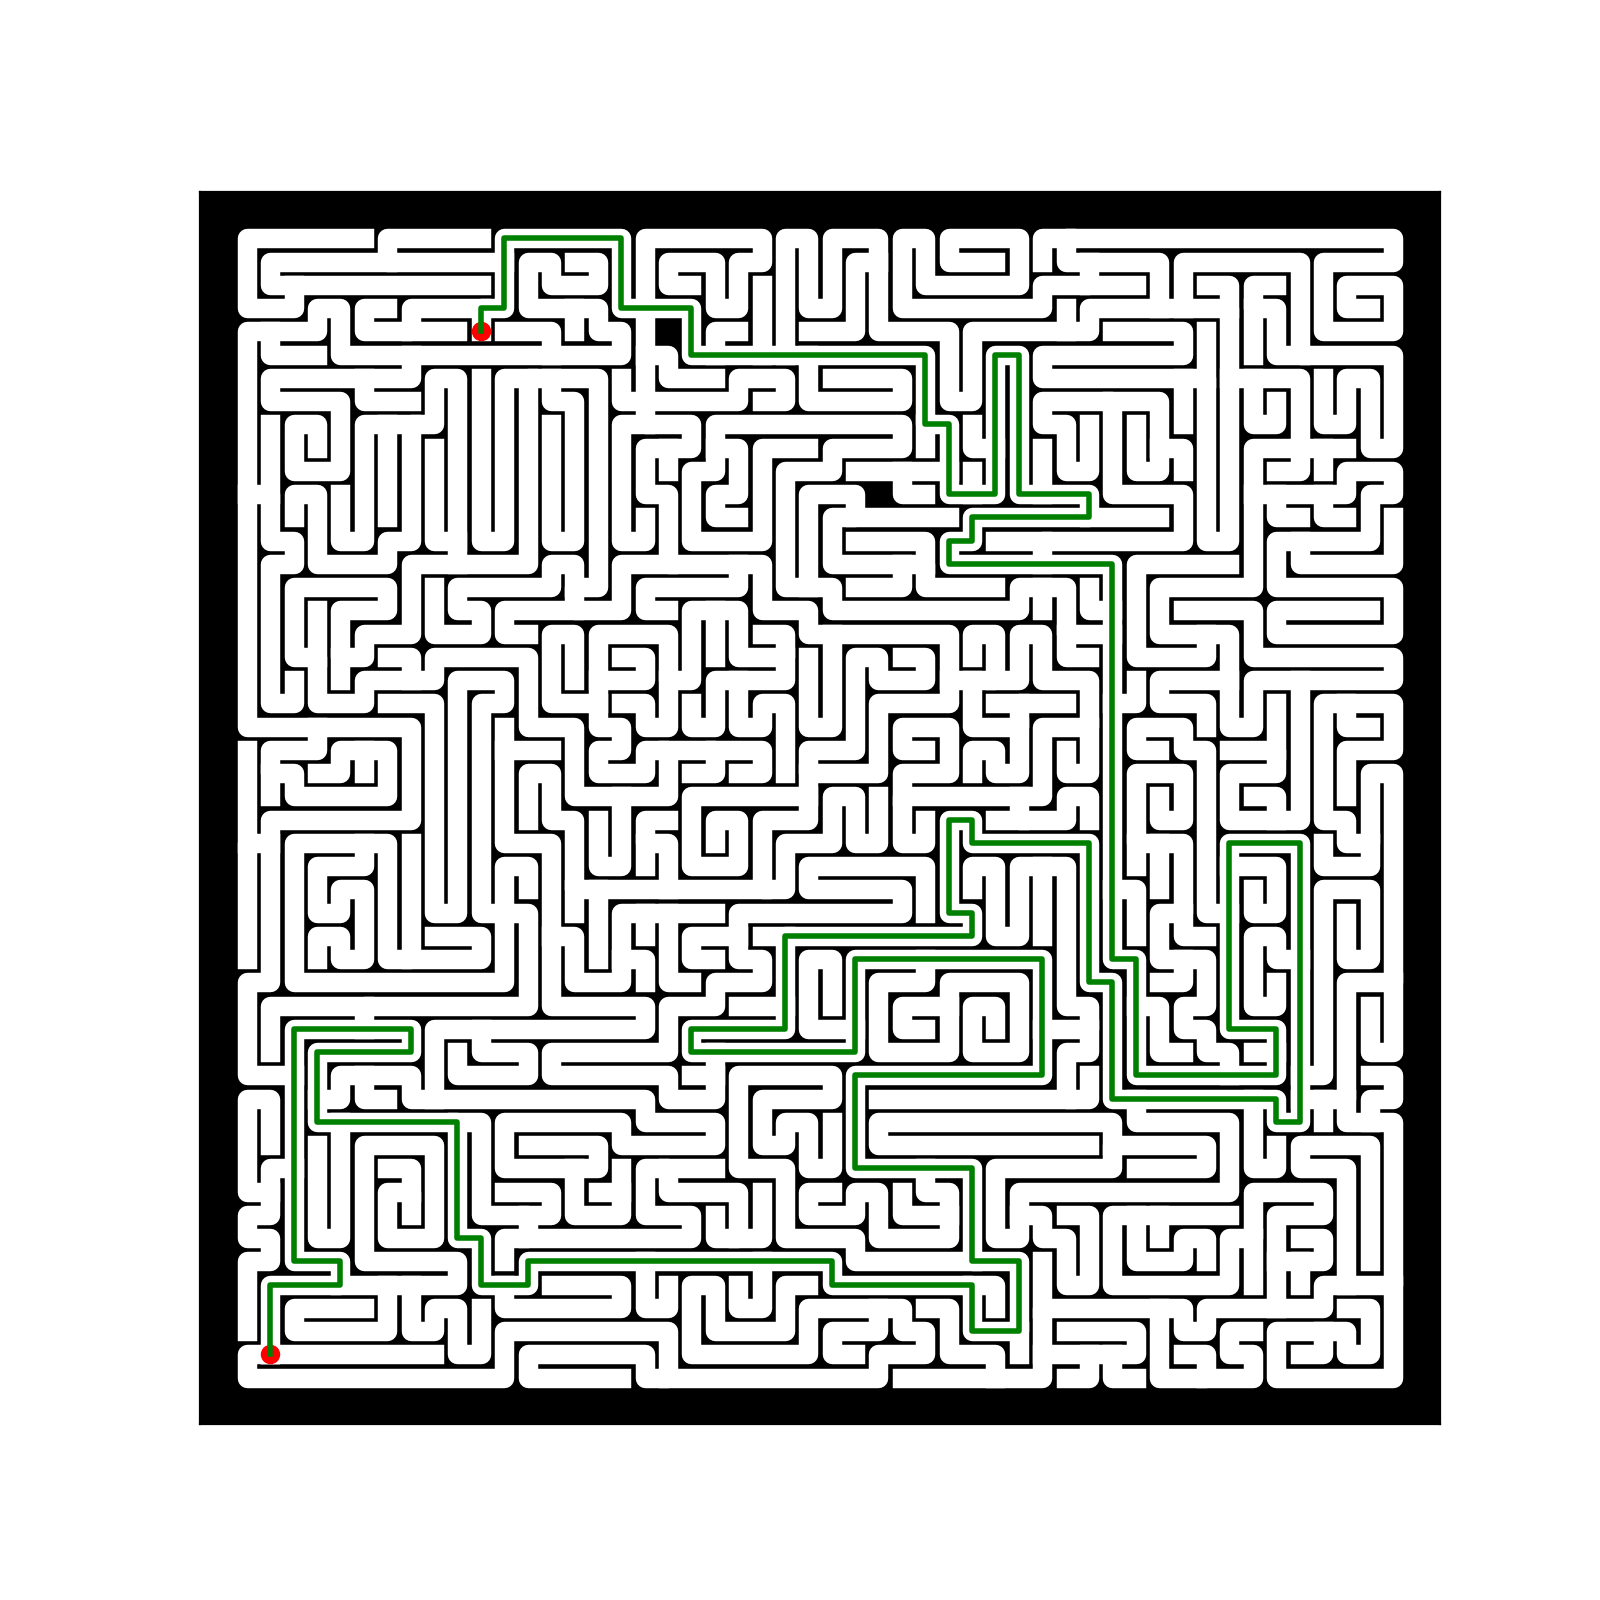

1 resets: 1


<IPython.core.display.Javascript object>


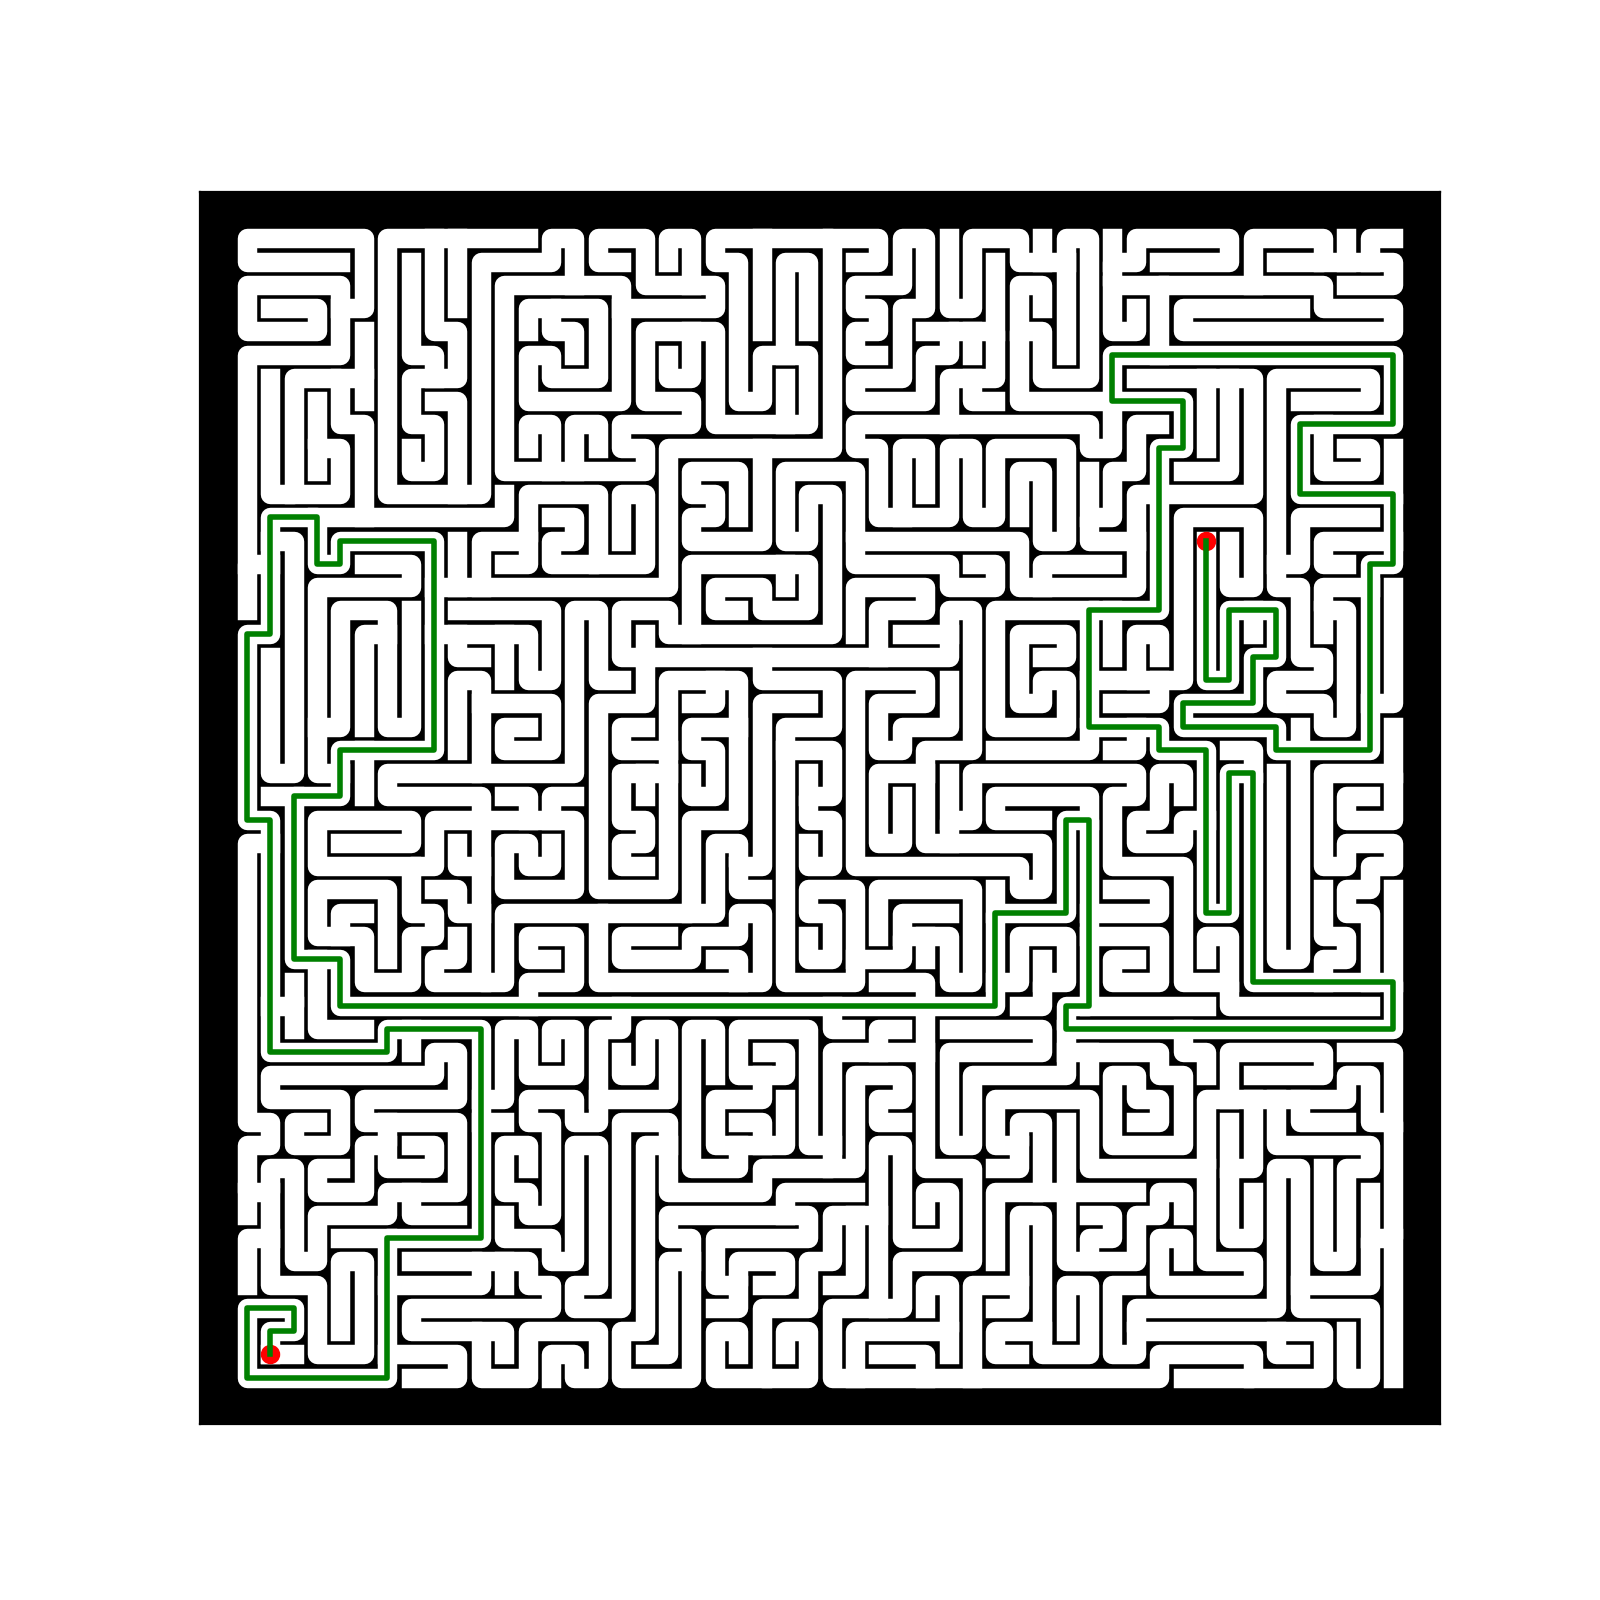

1 

<IPython.core.display.Javascript object>


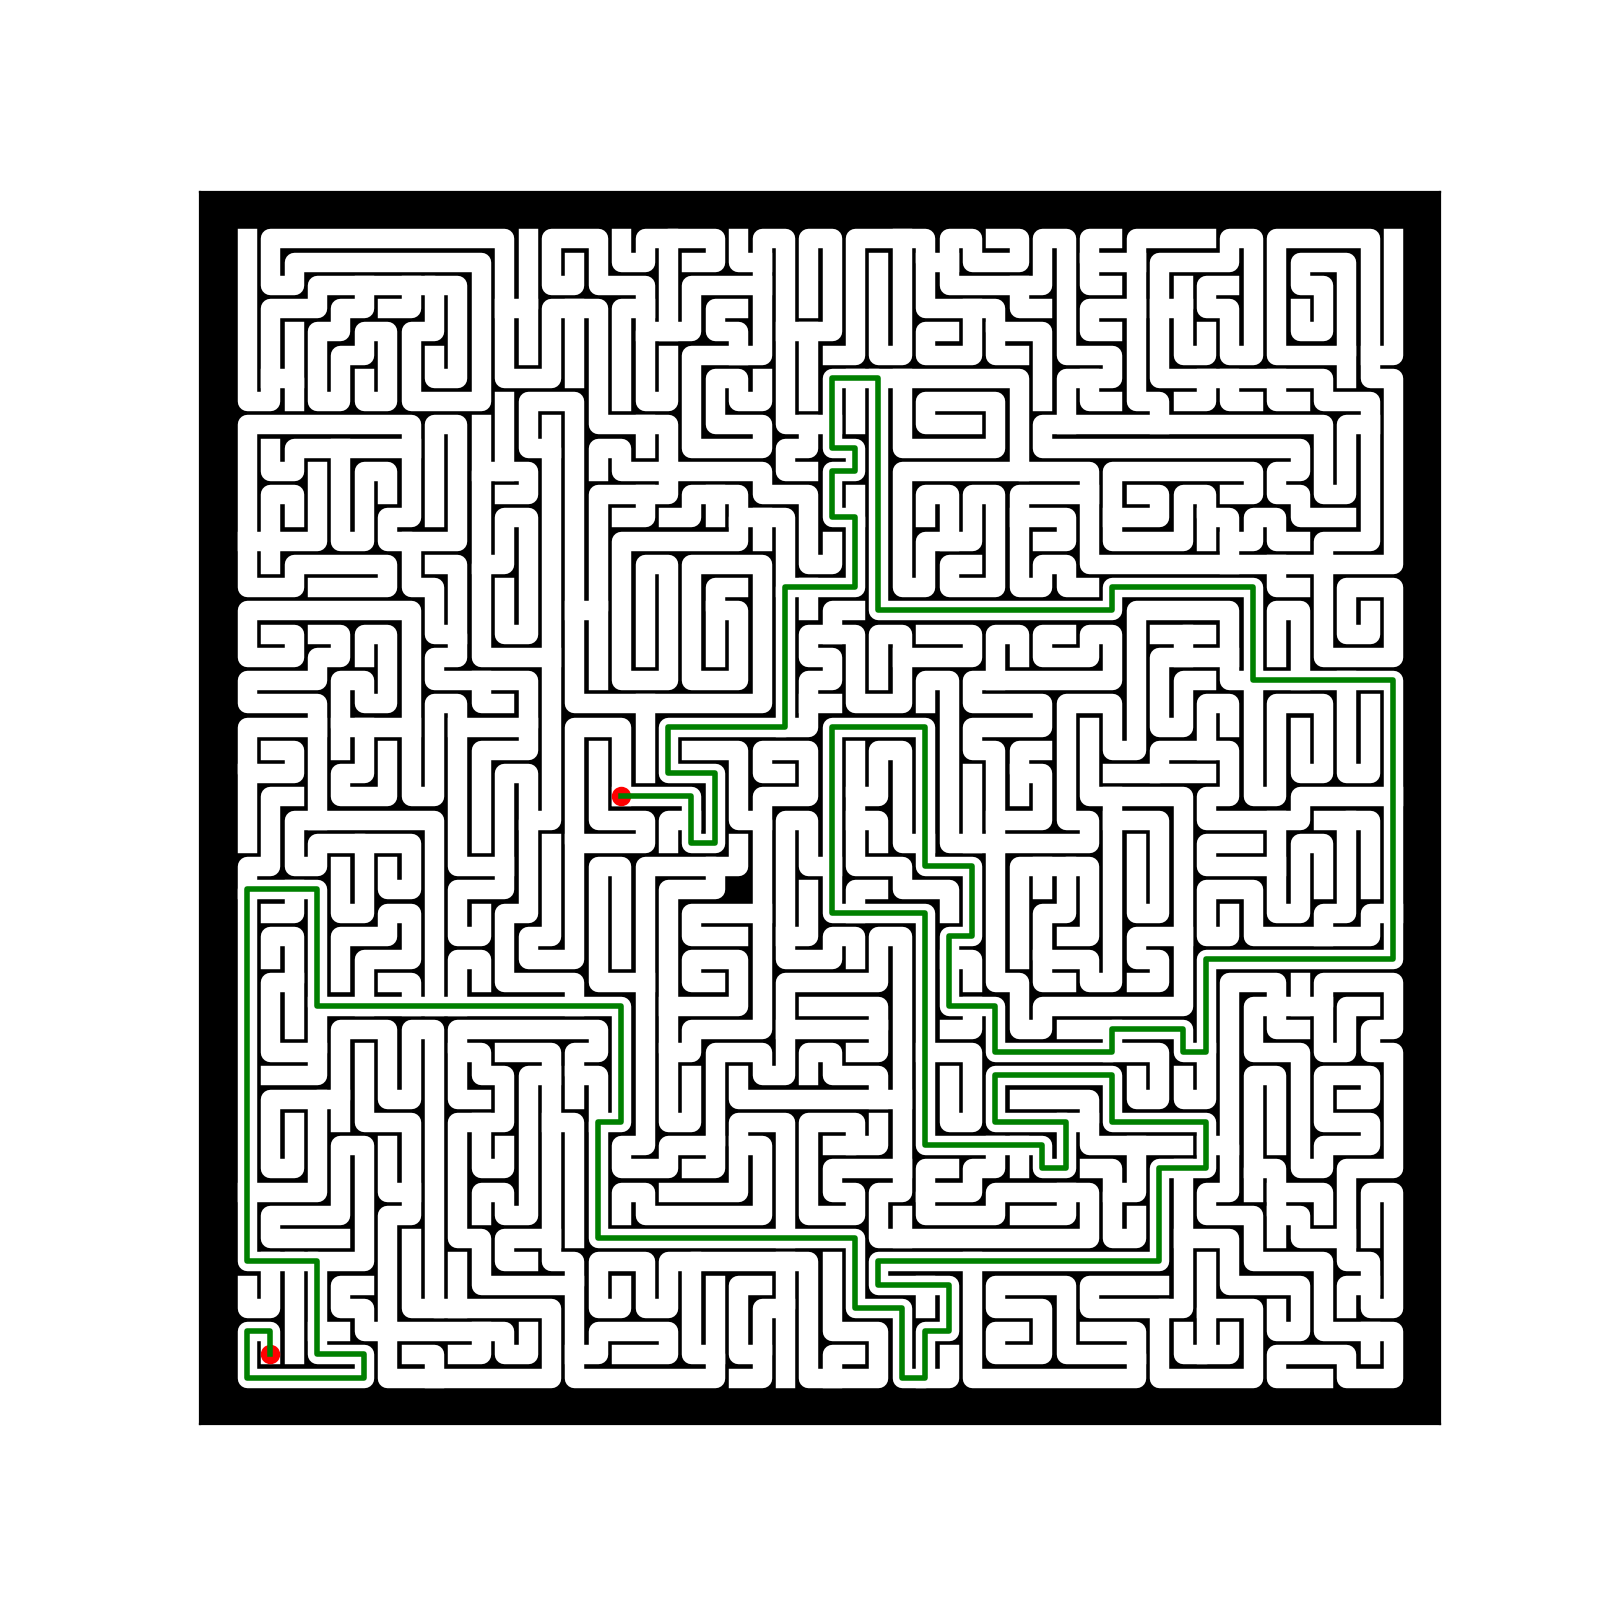

1 resets: 1


<IPython.core.display.Javascript object>


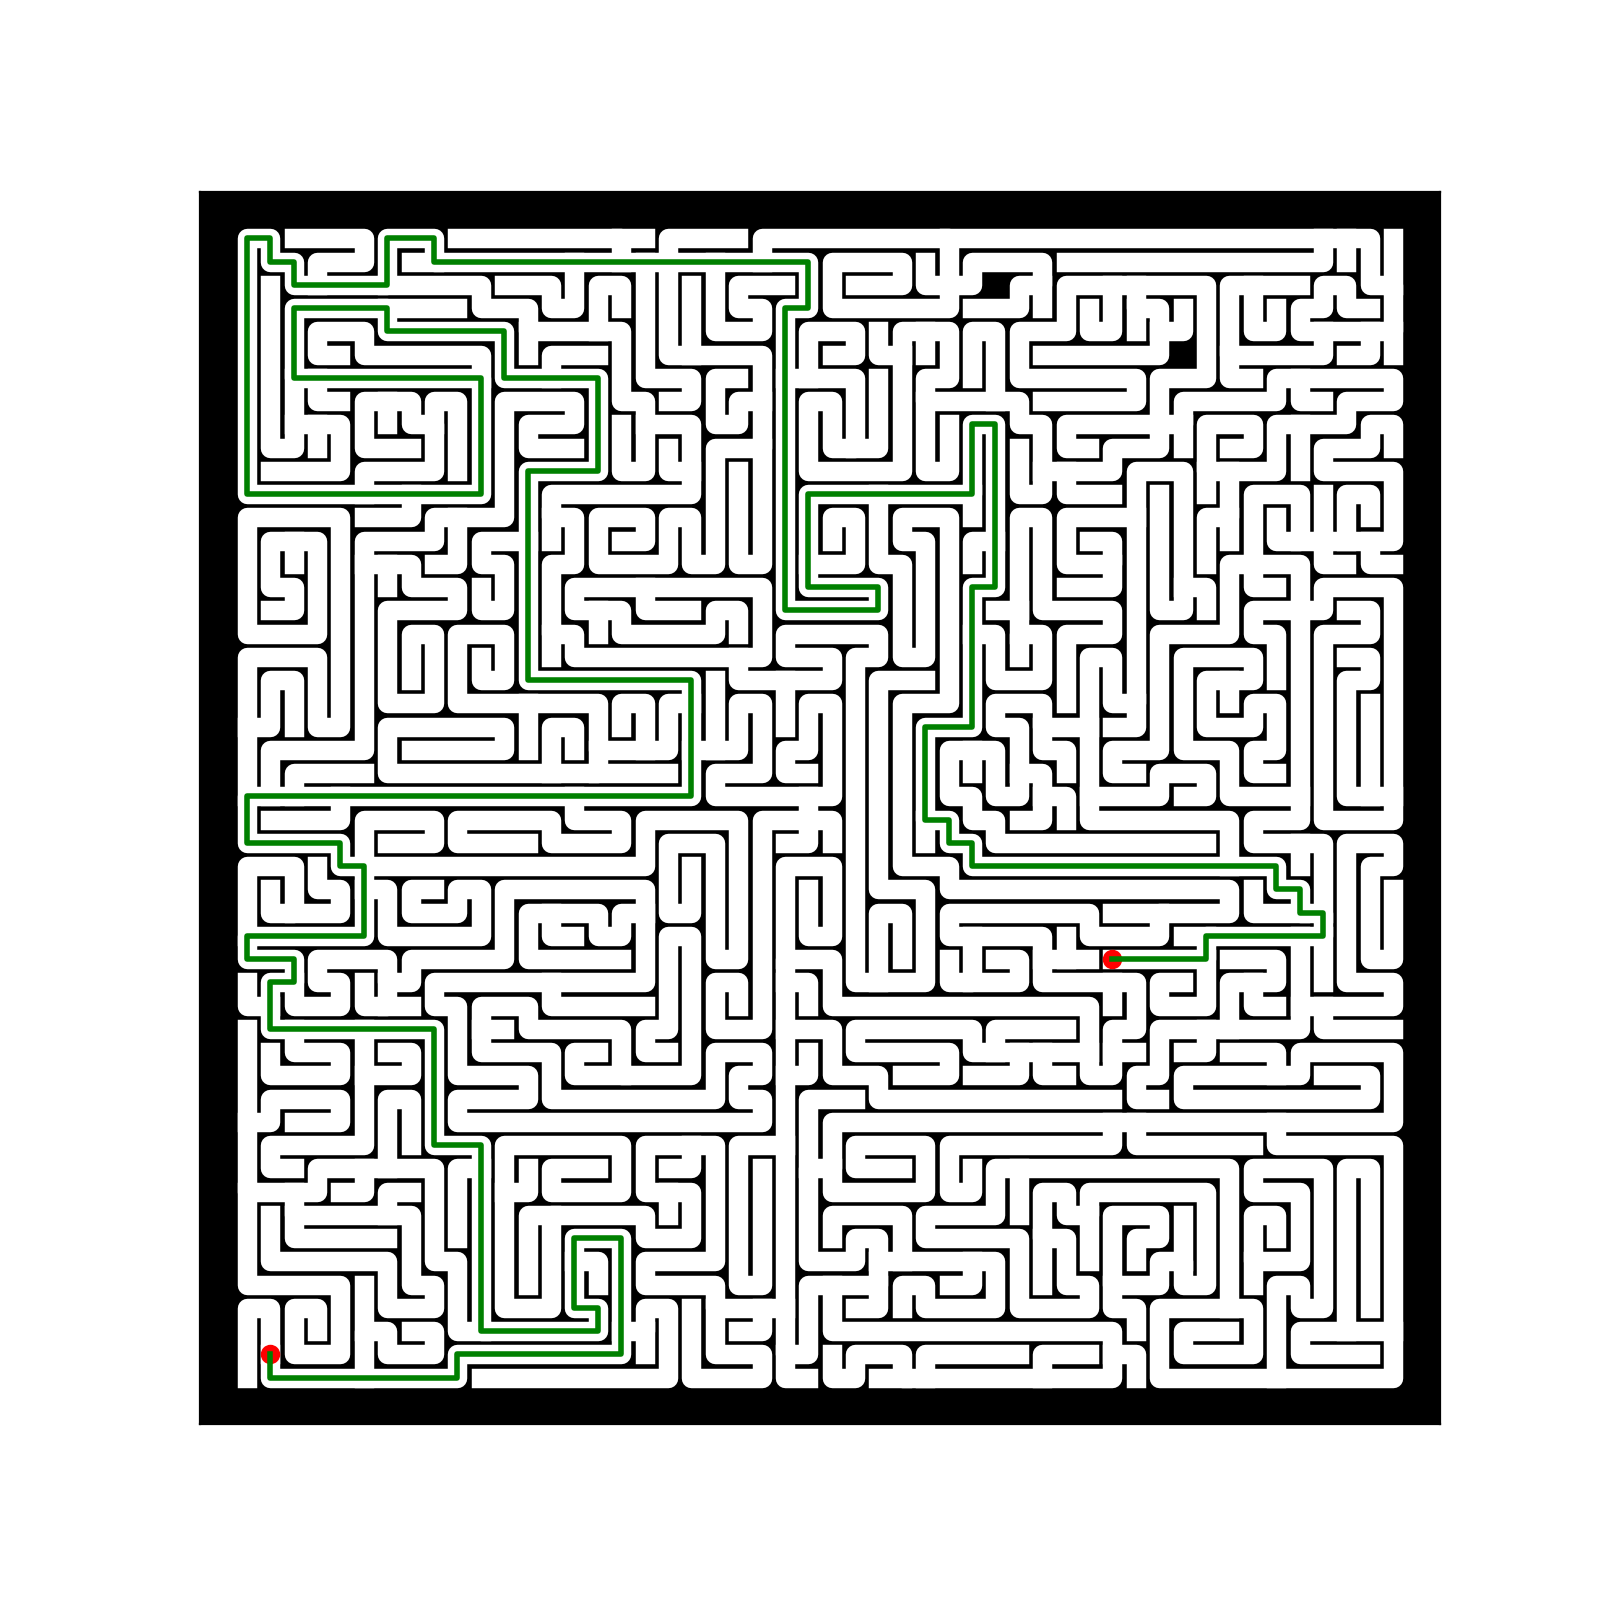

1 

<IPython.core.display.Javascript object>


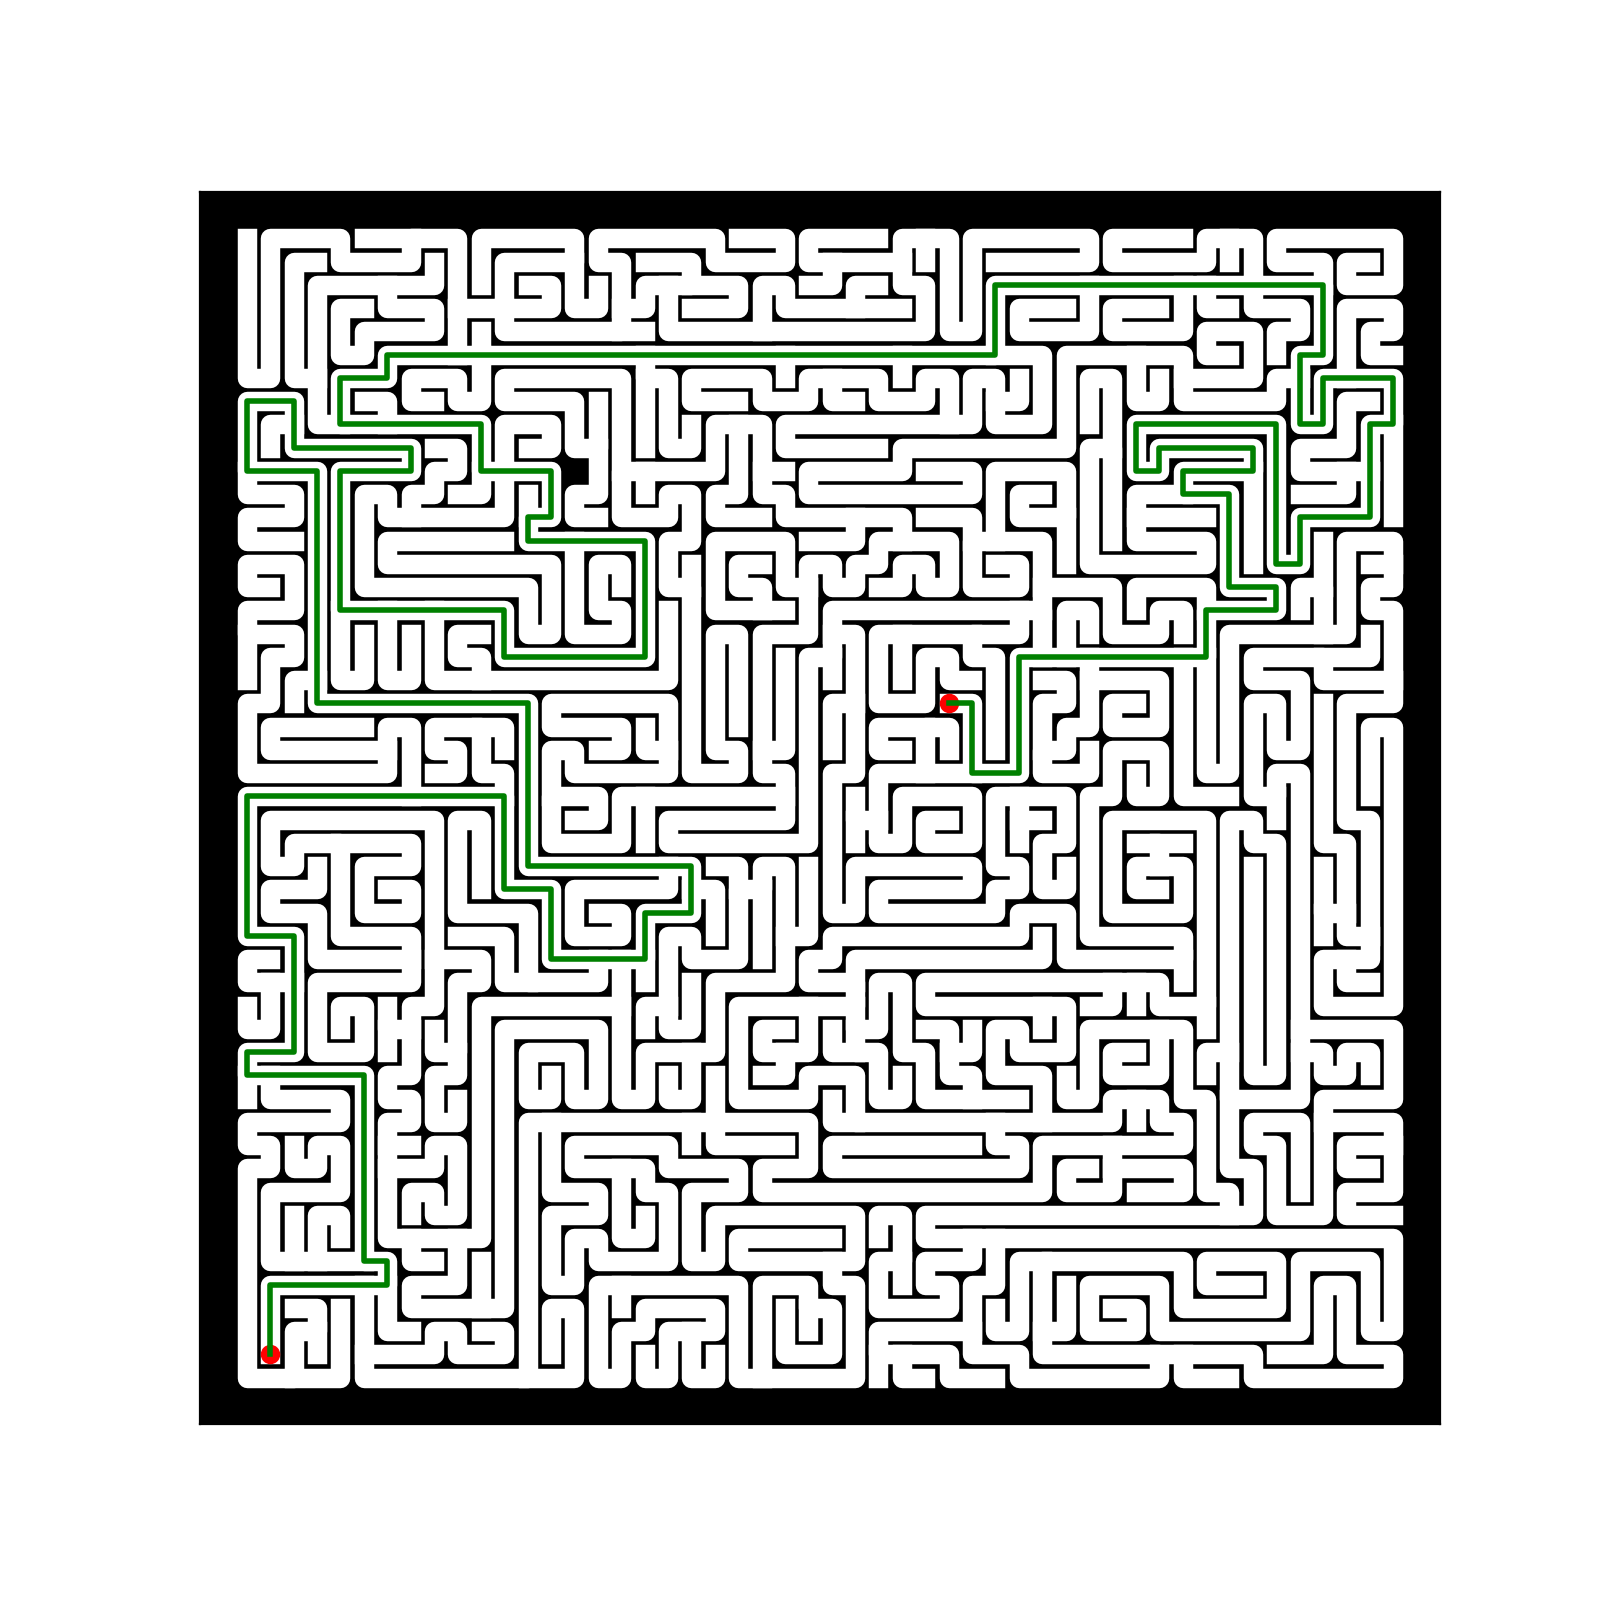

1 

<IPython.core.display.Javascript object>


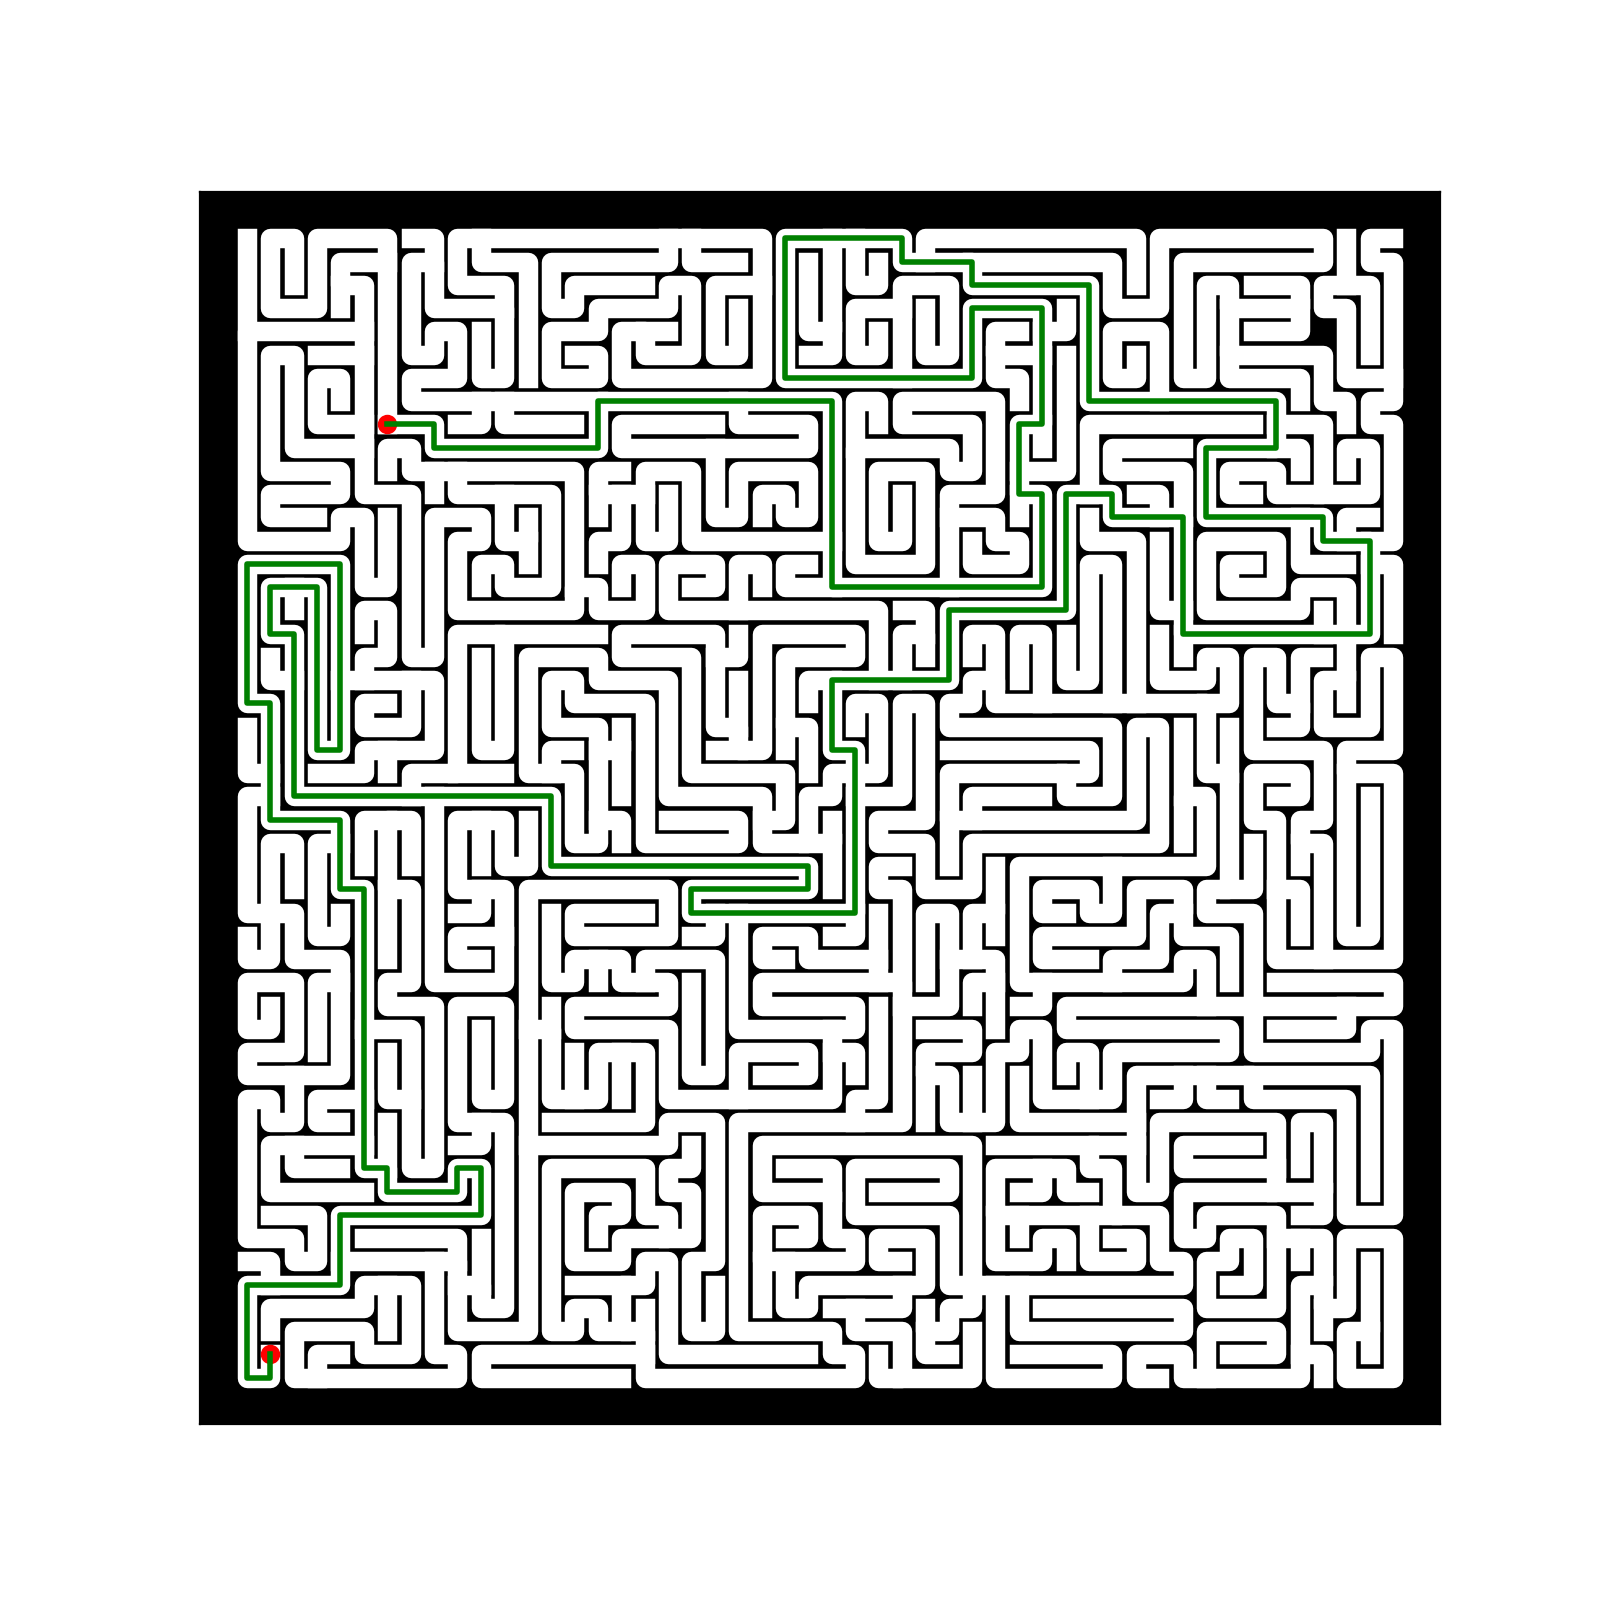

1 resets: 1


<IPython.core.display.Javascript object>


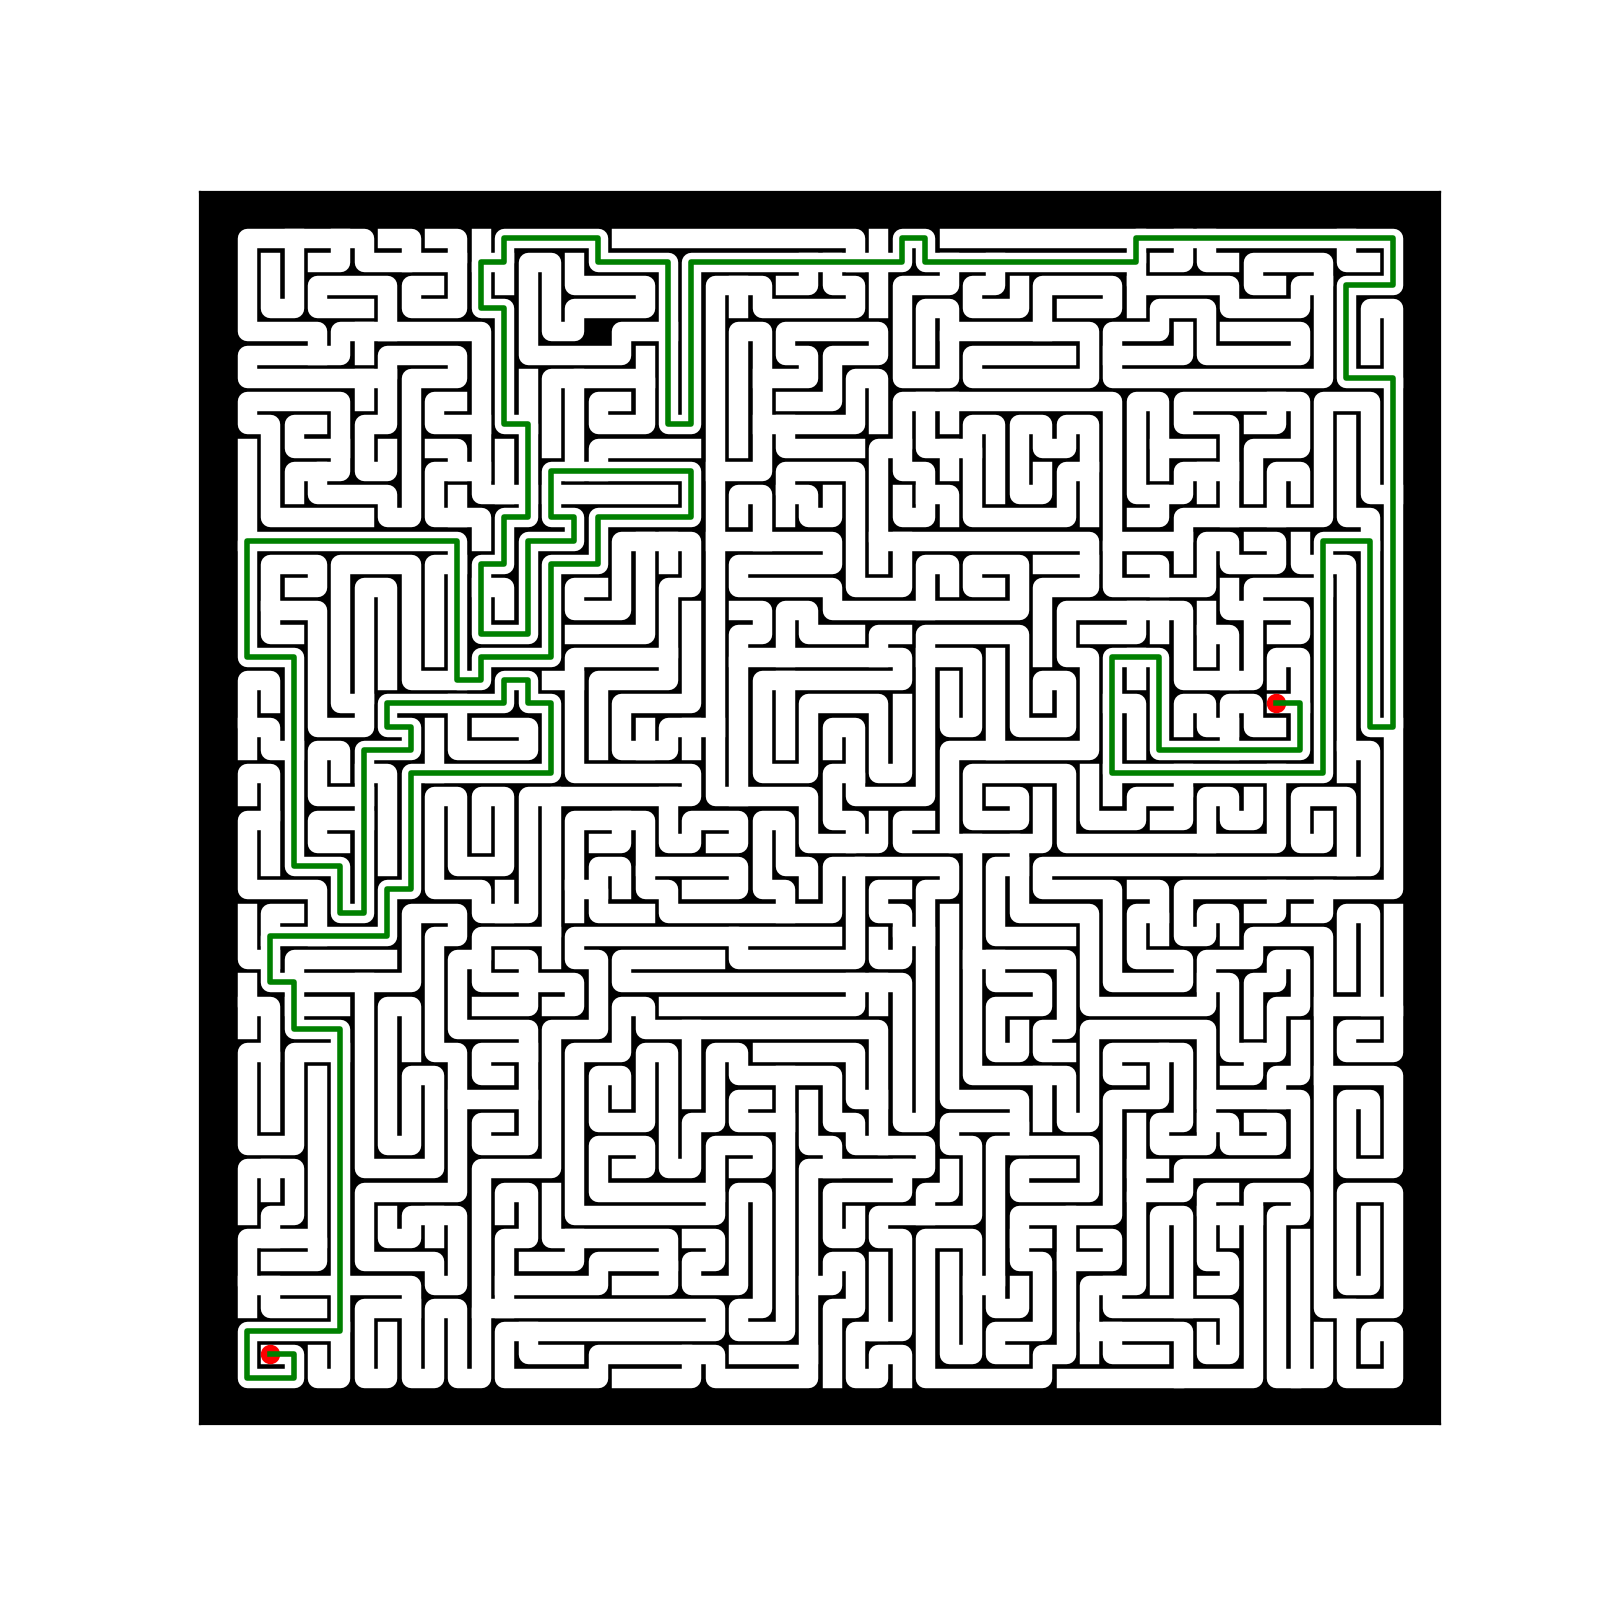

1 resets: 1


<IPython.core.display.Javascript object>


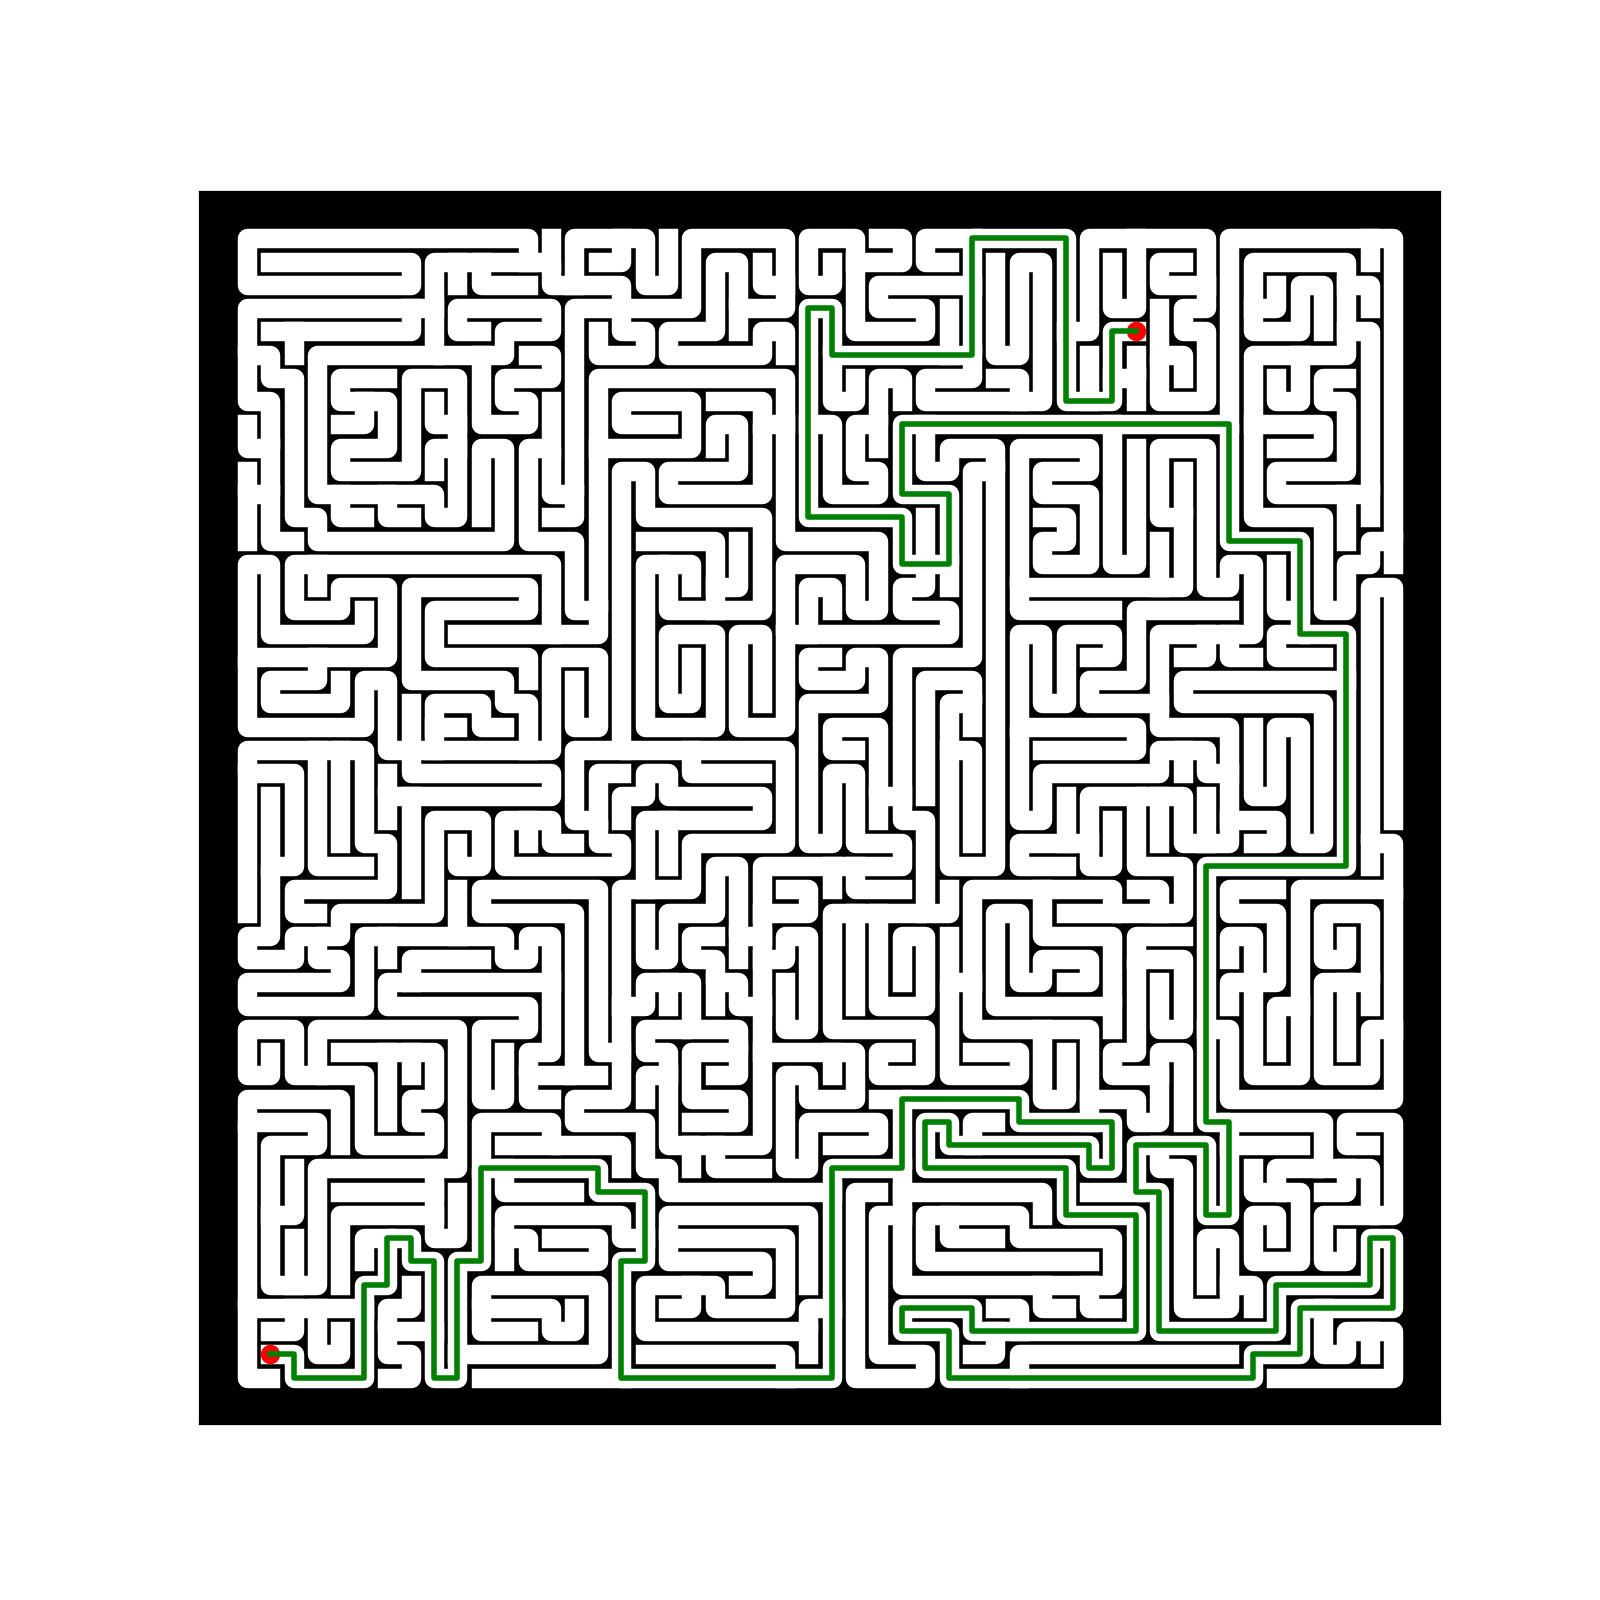

1 resets: 1


<IPython.core.display.Javascript object>


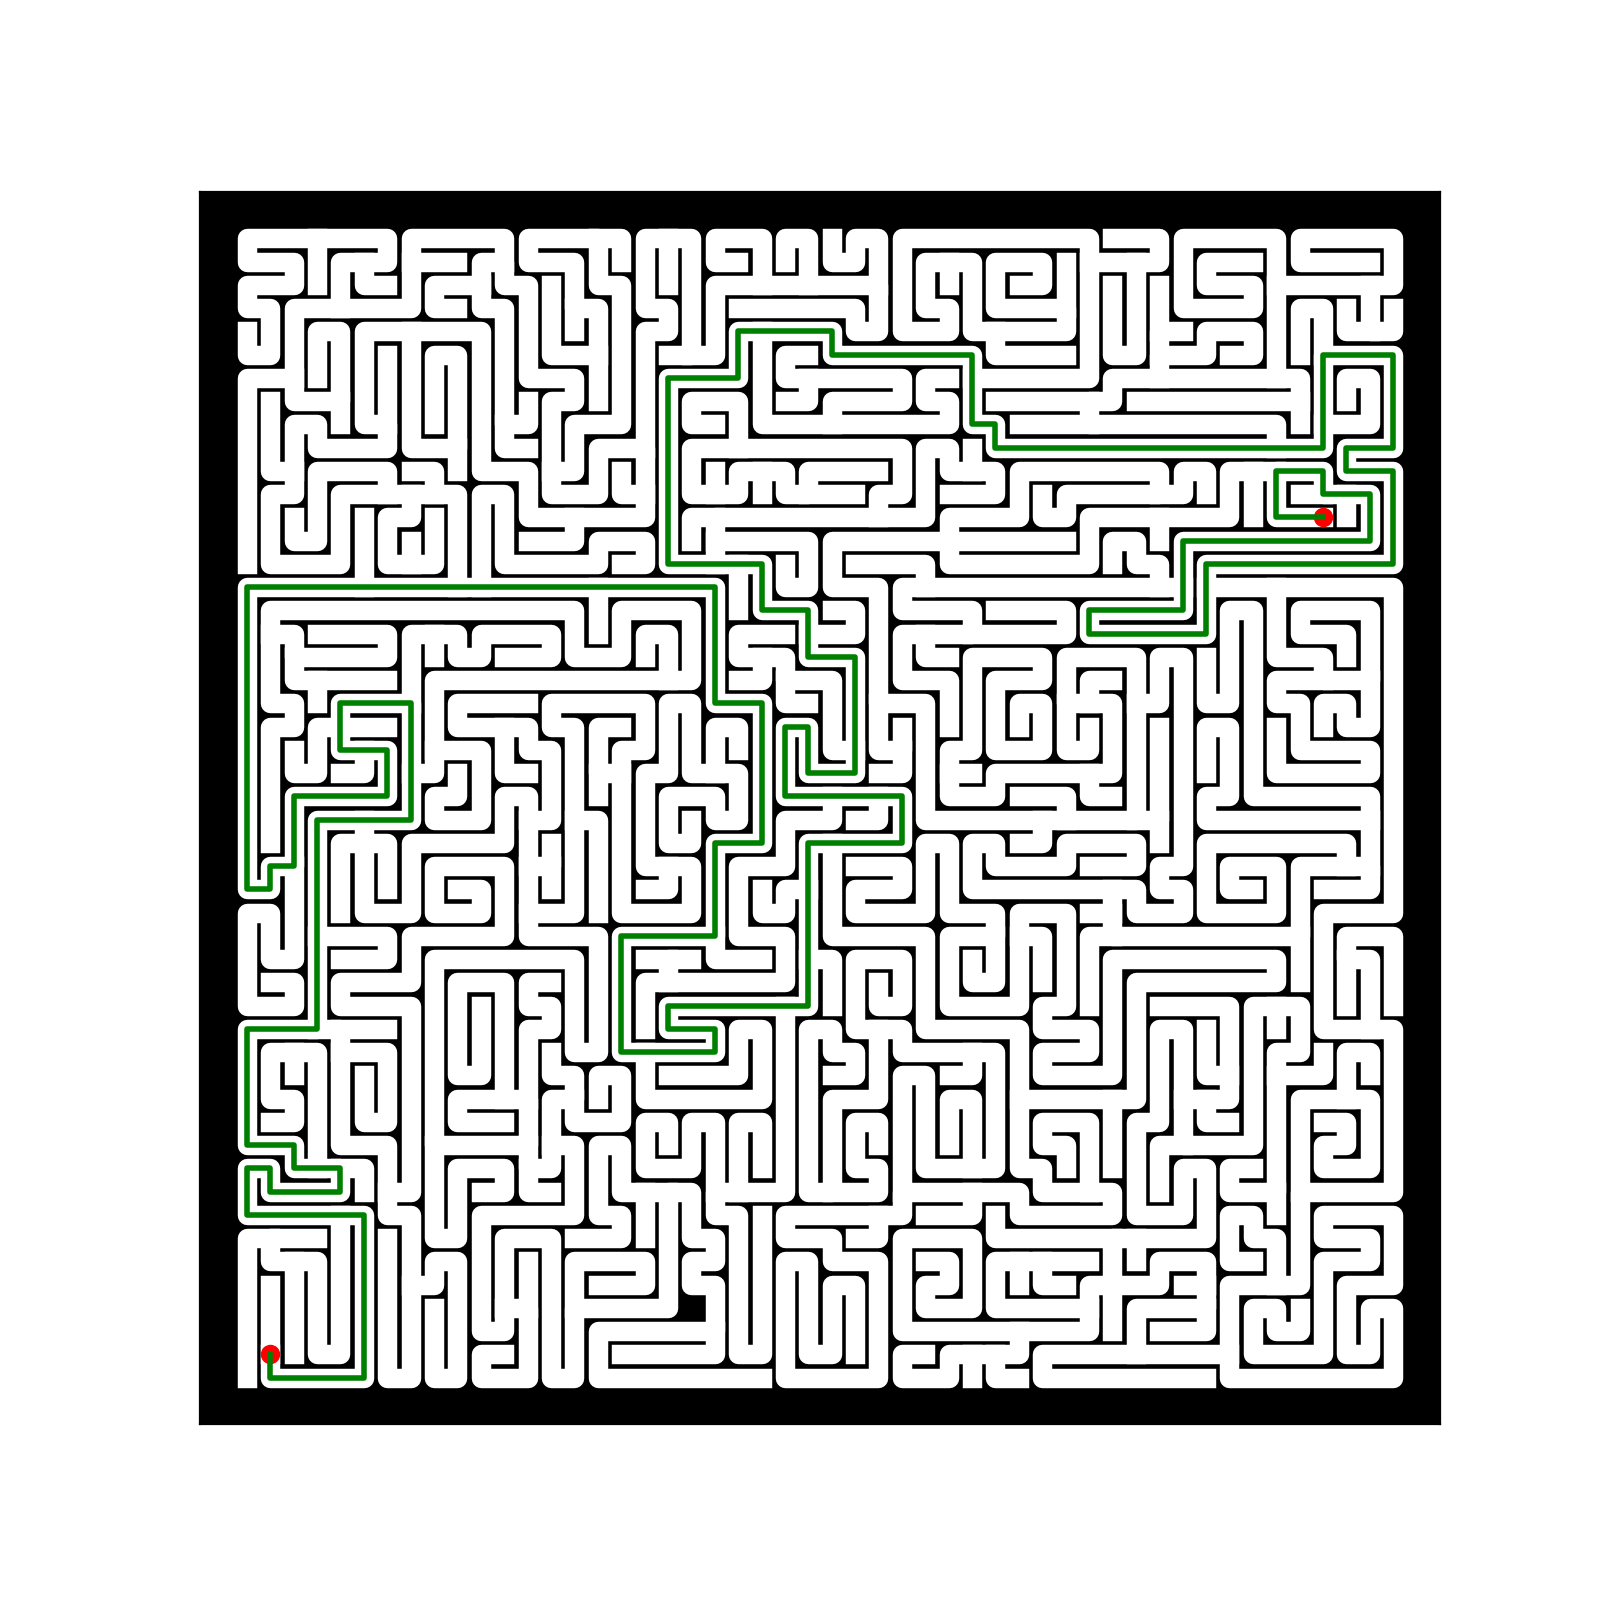

1 resets: 1


<IPython.core.display.Javascript object>


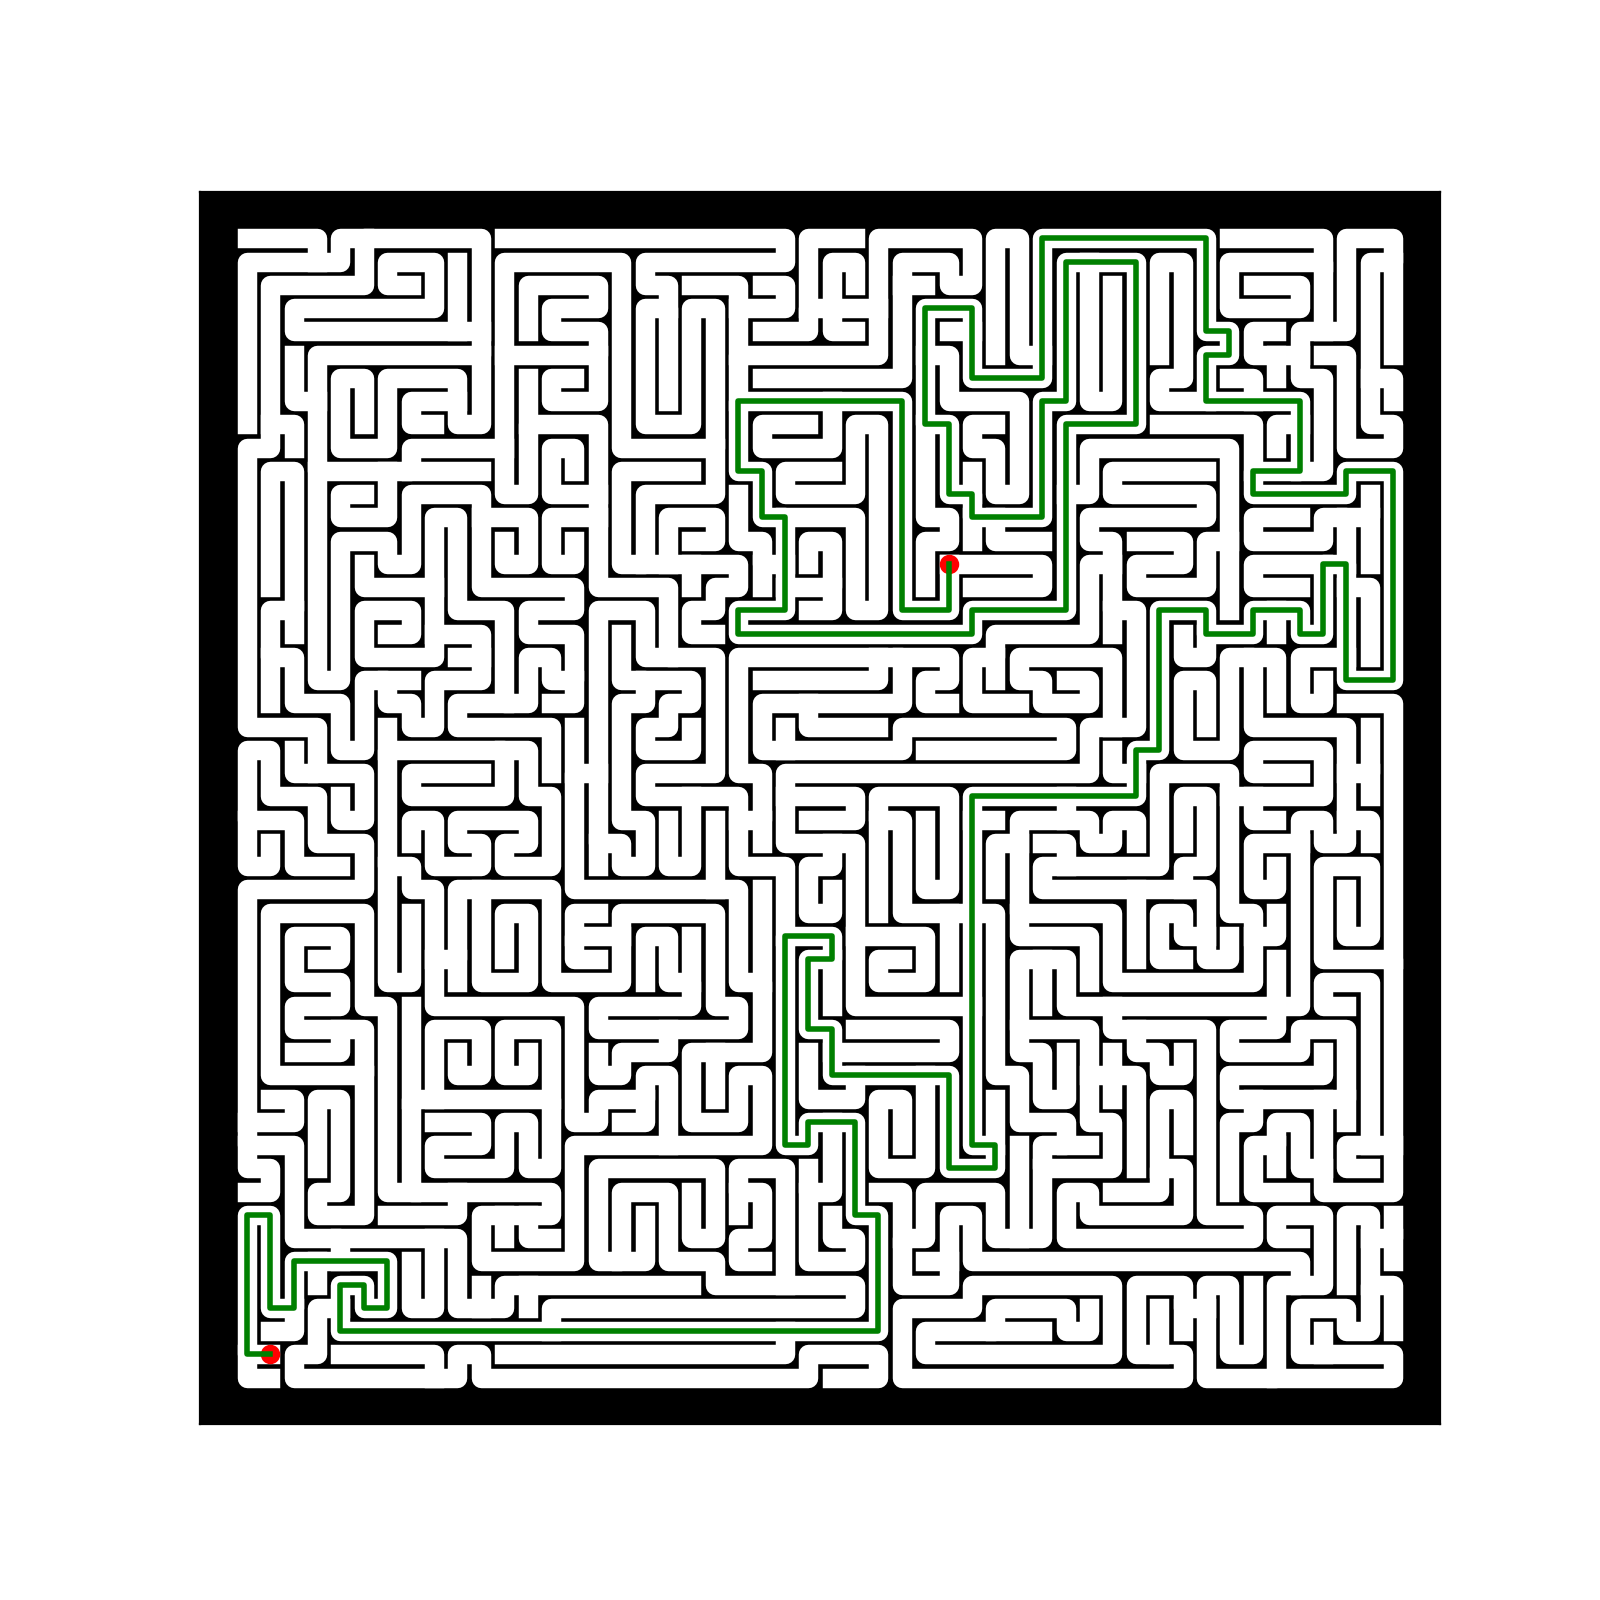

In [262]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import random

# conceptually, this program builds a maze by first generating a randomized path within an x*y matrix 
# with certain turning behavior and overall target length (maze "end" is arbitrarily wherever the path 
# target length is reached, then branches are added to the main path and branches off branches until 
# all the space within the matrix is filled. 

# 3 classes do the work: 1) grid: represents the space occupied and not yet occupied by maze paths as 
# they are added; 2) path is a class that forms a new line in the maze (whether the main path or a branch);
# 3) maze class organizes the construction of the maze using grid and path

class grid:
    
    def __init__(self,xmax,ymax):
        # only variables are to specify the x and y boundaries of the grid
        self.xmax=xmax
        self.ymax=ymax
        self.filled=[] # this variable keeps track of grid positions occupied by paths
        self.image = np.zeros([xmax,ymax]) # image is used to help find empty spots during maze construction
        
    def avail(self,xy):
        # this function checks to see if an x*y point on the grid is empty
        if any([xy[0]<0,xy[0]>=self.xmax,xy[1]<0,xy[1]>=self.ymax]):
            return False
        if xy in self.filled:
            return False
        else:
            return True
    def avail_nswe(self,xy):
        # this function checks for available (empty) xy points adjacent a given point and returns a list of available cardinal directions (n,s,e,w)
        deltas={'n':[0,1],'s':[0,-1],'w':[-1,0],'e':[1,0]}
        av = []
        for k,v in deltas.items():
            if self.avail(list(np.add(xy,v))):
                av.append(k)
        return av
    def fill(self,xy):
        # this function is to keep track of which spots are filled as maze path is constructed
        self.filled.append(xy)
        self.image[xy[0],xy[1]]=1
        
    def clear(self,points):
        # if a maze path is deleted (due to failure to meet criteria), must clear that path's positions from the grid
        self.image = np.zeros([self.xmax,self.ymax])
        self.filled = [x for x in self.filled if x not in points]
        
    def get_blanks(self):
        # checks for unoccupied positions in the grid, this is more efficient for large mazes than just trying random points. 
        # once unoccupied position is found, the function looks for an adjacent space that's part of a path, which could be a 
        # starting point for a new branch. It returns the variable "new_point" to the maze class
        zeros = np.where(self.image<1)
        count=0
        deltas={'n':[0,1],'s':[0,-1],'w':[-1,0],'e':[1,0]}
        
        coords = list(zip(zeros[0],zeros[1]))
        random.shuffle(coords)
        for xy in coords:
            for k,v in deltas.items():
                new_point = list(np.add(list(xy),v))
                if new_point in self.filled:
                    return new_point
        return None

        
        
class path:
    deltas={'n':[0,1],'s':[0,-1],'w':[-1,0],'e':[1,0]}
    
    def __init__(self,grid,xy=[1,1],length=100,turn_rate=0.4,maxtries=100,ignore_length=True,dead_ok=True):
        # constructor function
        self.turn_rate = turn_rate # lower number will make fewer random turns
        self.maxtries=maxtries # number of attempts allowed to make a main path before giving up
        self.length = length # length for main path, once reached main path will stop at arbitrary maze END
        self.xy=xy # current position of the path "head" as the path is growing, starts at 1,1 by default
        self.start = xy
        self.grid = grid # so that we can refer to the grid object to check available points
        self.tail = [xy] # list of all the points occupied by this path
        self.grid.fill(xy) # make sure grid object knows to add first point
        self.dead = False # used to track whether construction fails later
        self.dir = self.chdir() # sets a random cardinal direction
        self.ignore_length=ignore_length # for construction, length will be ignored if true (use False for main path)
        self.dead_ok=dead_ok # if true we will accept a path that fails to grow to target length (use for branches only)
        self.attempt_lengths = [] # this keeps a list of attempted growth lengths for troubleshooting/optimizing
        self.resets = 0
        self.end = self.grow() # this starts the growth loop!

        if self.end in [[-1,-1]]: 
            print('failed')
    def adv(self):
        # function for a single growth iteration; basically elongates the path along the cardinal direction,
        # may set a new direction if unavailable point is encountered or per random turning behavior. If unable
        # to advance, checks for any available direction, and if none available makes the path "dead"
        if self.grid.avail(list(np.add(self.xy,self.deltas[self.dir]))):
            if np.random.rand()<self.turn_rate: # randomly makes the path turn based on turn rate
                av = self.grid.avail_nswe(self.xy) # av = available directions for growth
                if len(av)<1:
                    self.dead = True
                    return
                self.dir = np.random.choice(av)
        else:
            av = self.grid.avail_nswe(self.xy)
            if len(av)<1:
                self.dead = True
                return
            else:
                self.dir = np.random.choice(av)
        self.xy=list(np.add(self.xy,self.deltas[self.dir]))
        self.tail.append(self.xy) # adds new point to path points
        self.grid.fill(self.xy) # adds new point to grid
        
    def erase(self,mode='partial'):
        # erasing the whole path every iteration is inefficient. It's desirable to reuse some of the attempts but not to over-commit
        # will try the following: choose a random point along the length of the path and erase from there, starting at that point
        self.attempt_lengths.append(len(self.tail)) # keeps track of lengths of attempt
        if mode=='partial':
            sel = max([3,len(self.tail)-np.random.choice([3,6,9,12,15,30,100,400])])
        else:
            self.resets+=1
            if self.resets in range(1,10000,10):
                print('resets:',self.resets)
            sel = 1
        self.xy = self.tail[sel]
        self.grid.clear(self.tail[sel+1:]) # this communicates to grid which points to trash (everything after random point)
        self.tail = self.tail[0:sel+1] # +1 to be inclusive of the point chosen (up to the random point)
        # to trash a path and start over, must ensure the grid is updated
        self.dead = False
        
    def chdir(self):
        # change direction randomly to new cardinal direction
        return np.random.choice(['n','s','e','w'])
    
    def grow(self):
        # growth loop, grows path until target length reached or path cannot grow; note that sometimes failed growth is tolerable (for branches) and sometimes not (for main path)
        done = False
        count = 0
        while all([done==False,count<self.maxtries]):
            if count in range(1,self.maxtries,1000):
                print(count,end=' ')
                
            while all([self.dead==False,any([self.ignore_length,self.length>len(self.tail)])]):
                # note that if self.ignore_length=True it doesn't stop for length reasons
                self.adv() # advance function above
            if self.dead == True:
                if self.dead_ok: # for branches we are OK with this; stop growth and accept final path
                    done=True
                else: # for main path, this is failure, must erase path and start over
                    count = count+1
                    self.erase()
            elif len(self.tail)>=self.length: # path target length reached, 
                if self.dead_ok:
                    done=True
                elif all([max([x[0] for x in self.tail])>self.grid.xmax*0.85,max([y[1] for y in self.tail])>self.grid.ymax*0.85]):
                    # this sets a requirement that the path reach beyond 85% of the x and y of the grid before terminating to make sure we cover more of the grid
                    done=True
                else:
                    # terminate the path and start over
                    count = count+1
                    self.erase('start over')
            else:
                print('hmmmm')
        if count >= self.maxtries:
            return [-1,-1] # placeholder value for failed path, lets maze class know we failed
        return self.xy
    
    
class maze:
    # this class organizes the construction of the maze
    def __init__(self,xmax,ymax,length,turn_rate=0.4,maxtries=100):
        self.grid = grid(xmax,ymax)
        self.main_path = path(self.grid,[1,1],length,turn_rate,maxtries,ignore_length=False,dead_ok=False) # makes a main path
        self.start = self.main_path.start
        self.end = self.main_path.end
        self.fail = False
        
        self.branches = []
        self.branches2 = []
        if self.end in [[-1,-1]]: # this value is returned from path if it fails to make a path
            
            # generate histogram from the main_path.attemp_lengths:
            hist,bins = np.histogram(self.main_path.attempt_lengths,bins=100)
            
            fig,ax = plt.subplots()
            print(hist)
            print(bins)
            plt.bar(bins[:-1],hist)
            plt.show()
            
            
            print('failed to make main path, try again')
            self.fail = True


    def add_branches(self,from_main=20,from_random=1000,from_blank=1000):
            # this block adds branches to the maze, each one a new path object
            # branches are created in three ways:
                # starting from random point off the main path (from_random)
                # starting from a random point off ANY path/branch
                # starting from a random point on a path next to an identified empty spot (this is done late in construction to increase efficiency of filling sparse blank spaces)
        for i in range(from_main): # branches to be added to main path
            self.branches.append(path(self.grid,self.main_path.tail[np.random.randint(0,len(self.main_path.tail))],20,0.4,1))
        count = 0
        while count<from_random: # branches to be added to any path/branch including the main path
            count = count+1
            self.branches.append(path(self.grid,self.grid.filled[np.random.randint(0,len(self.grid.filled))],20,0.4,1))
        for i in range(from_blank): # branches to be added next to blank spaces
            blank = self.grid.get_blanks()
            if blank is None:
                break
            else:
                self.branches2.append(path(self.grid,blank,20,0.4,1))
        
    def graph(self,line_width=5,padding=1):
        # this generates a maze image using matplotlib library. It does not include the solution so that an unsolved figure can be saved to disk
        #
        #    !!!! key arbitrary variable is the linewidth below, which needs to be adjusted based on the overall maze figure size and x/y grid properties
        #
        
        self.fig,self.ax = plt.subplots(figsize=[8,8])
        
        def plotpath(p,c):
            xx = [xy[0] for xy in p.tail]
            yy = [xy[1] for xy in p.tail]
            self.ax.plot(xx,yy,'-',color=c,linewidth=line_width)

        
        for b in self.branches:
            plotpath(b,'w')
        for b in self.branches2:
            plotpath(b,'w')
            
        plotpath(self.main_path,'w')
        
        self.ax.plot(self.main_path.tail[0][0],self.main_path.tail[0][1],'o',color='r')
        self.ax.plot(self.main_path.tail[-1][0],self.main_path.tail[-1][1],'o',color='r')
        
        self.ax.set_xlim([-padding-1,self.grid.xmax+padding])
        self.ax.set_ylim([-padding-1,self.grid.ymax+padding])
        self.ax.set_facecolor('k')
        self.ax.axes.xaxis.set_visible(False)
        self.ax.axes.yaxis.set_visible(False)
        
    def graph_solution(self):
        # this graphs the maze solution on top of the figure, so solved maze can be exported to disk
        def plotpath_narrow(p,c):
            xx = [xy[0] for xy in p.tail]
            yy = [xy[1] for xy in p.tail]
            self.ax.plot(xx,yy,'-',color=c,linewidth=2)
            
        plotpath_narrow(self.main_path,'g')
        

# below is an example of how to use the above, it will generate one or two mazes and save solved and unsolved images to disk
        
for i in range(10): # make 10 mazes
    M = maze(50,50,300,0.4,50000)
    # make a 50x50 maze with target length 300 points, turning activity 0.4, 50000 attempts to generate the main path
    if M.fail:
        continue
    M.add_branches(from_main=15,from_random=400,from_blank=600)
    M.graph(line_width=7,padding=1)
    M.fig.savefig('maze'+str(i)+'.pdf')
    M.graph_solution()
    M.fig.savefig('maze'+str(i)+'_solution.pdf')
